In [4]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import log
import  numpy as np
import matplotlib.patches as mpatches

import utils.densities as distributions
from main import parse_arguments
import sample as zodmc
import utils.metrics as metrics
import utils.plots as plots
from samplers.parallel_tempering import parallel_tempering
from samplers.ula import get_ula_samples

AttributeError: module 'wandb.sdk' has no attribute 'lib'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d = 2
num_modes = 3
s1, s2, s3 = .1, .1, .1 # These are squared
id = torch.eye(d,dtype=torch.float32,device=device).unsqueeze(0)
weights = torch.ones((num_modes),dtype=torch.float32,device=device)/num_modes
means = torch.tensor([[0.,0.],[5.,5.], [-6.,-8.0]],dtype=torch.float32,device=device)
covs = torch.cat([s1 * id, s2 * id, s3 * id],dim=0)
gaussians = [distributions.MultivariateGaussian(means[i],covs[i]) for i in range(num_modes)]
dist = distributions.MixtureDistribution(weights, gaussians)

In [ ]:
def rejection_sampler(num_proposals):
    s = max(s1,s2) * 10
    for i in range(num_modes):
        M = max((s/s1)**(d/2), (s/s2)**(d/2) * torch.exp(torch.sum(means[i]**2)/2/(s-s2)).cpu().detach().item())
    prop_dist = distributions.MultivariateGaussian(torch.tensor([0.,0.],dtype=torch.float32,device=device), id[0] * s)
    prop = torch.randn((num_proposals,d),device=device).to(dtype=torch.float32) * s**.5
    rand = torch.rand((num_proposals,1),device=device).to(dtype=torch.float32)
    acc = torch.exp( dist.log_prob(prop) - prop_dist.log_prob(prop) - log(M)) > rand
    acc = acc.expand((-1,2))
    return prop[acc].view(-1,d)

def get_zodmc_config(num_samples):
    config = parse_arguments()[0]
    config.score_method = 'p0t'
    config.p0t_method = 'rejection'
    config.dimension = d
    config.num_batches = 1
    config.sampling_batch_size = num_samples
    config.num_estimator_samples = 5000
    config.sampling_method = 'ei'
    config.T = 2.
    config.sampling_eps = 5e-3
    config.disc_steps = 15
    return config

100%|██████████| 49/49 [00:00<00:00, 455.33it/s]


Oracle complexity 50000000 generated 0
666


Oracle complexity 49950000 generated 666


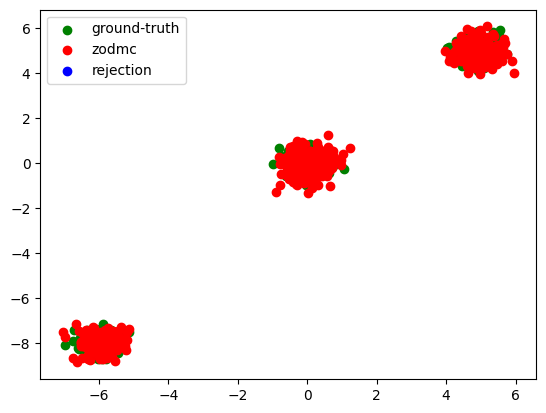

In [ ]:
# Rejection
num_proposals = 1000000
num_iters = 50
rej_samples = rejection_sampler(num_proposals)
for i in tqdm(range(num_iters - 1)):
    samples = rejection_sampler(num_proposals)
    rej_samples = torch.cat((rej_samples,samples),dim=0)
oracle_complexity_rej = num_proposals * num_iters
print(f'Oracle complexity {oracle_complexity_rej} generated {rej_samples.shape[0]}')

# ZODMC
num_rej_samples = rej_samples.shape[0]
config = get_zodmc_config(num_rej_samples)
num_zodmc_samples = oracle_complexity_rej//(config.disc_steps * config.num_estimator_samples)
config.sampling_batch_size = num_zodmc_samples
print(config.sampling_batch_size)
zodmc_samples= zodmc.sample(config,distribution=dist)
oracle_complexity_zodmc = config.num_estimator_samples * config.disc_steps * config.sampling_batch_size
print(f'Oracle complexity {oracle_complexity_zodmc} generated {config.sampling_batch_size}')


ground_truth_samples = dist.sample(num_zodmc_samples)
plt.scatter(ground_truth_samples[:,0].cpu().detach().numpy(),
            ground_truth_samples[:,1].cpu().detach().numpy(),color='green')
plt.scatter(zodmc_samples[:,0].cpu().detach().numpy(),
            zodmc_samples[:,1].cpu().detach().numpy(),color='red')
plt.scatter(rej_samples[:,0].cpu().detach().numpy(),
            rej_samples[:,1].cpu().detach().numpy(),color='blue')
plt.legend(['ground-truth','zodmc','rejection'])
plt.show()



tensor([0.2000, 0.3600, 0.5200, 0.6800, 0.8400, 1.0000], device='cuda:0')


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [16:00<00:00, 104.13it/s]


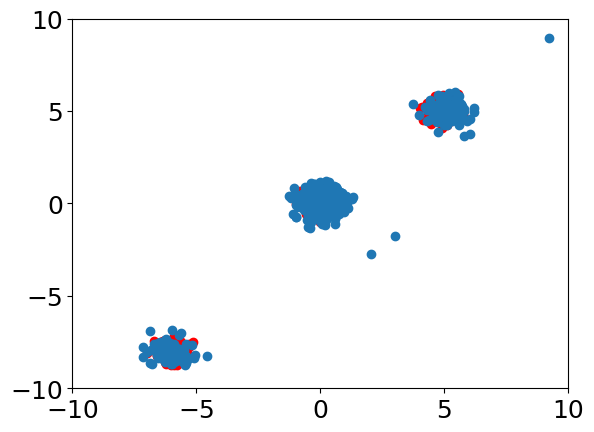

In [ ]:
x0 = torch.randn((num_zodmc_samples,2),dtype=torch.float32, device=device) 
num_chains = 6
betas = torch.linspace(.2,1.,num_chains, dtype=torch.float32,device=device)
print(betas)
num_iters = 100000
parallel_temp_samples = parallel_tempering(dist,x0,betas,num_iters,.1)
oracle_complexity_parallel = 6 * num_chains * num_iters
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.scatter(ground_truth_samples[:,0].cpu().detach().numpy(),
            ground_truth_samples[:,1].cpu().detach().numpy(),color='red')
plt.scatter(parallel_temp_samples[:,0].cpu().detach().numpy(),
            parallel_temp_samples[:,1].cpu().detach().numpy())
plt.show()

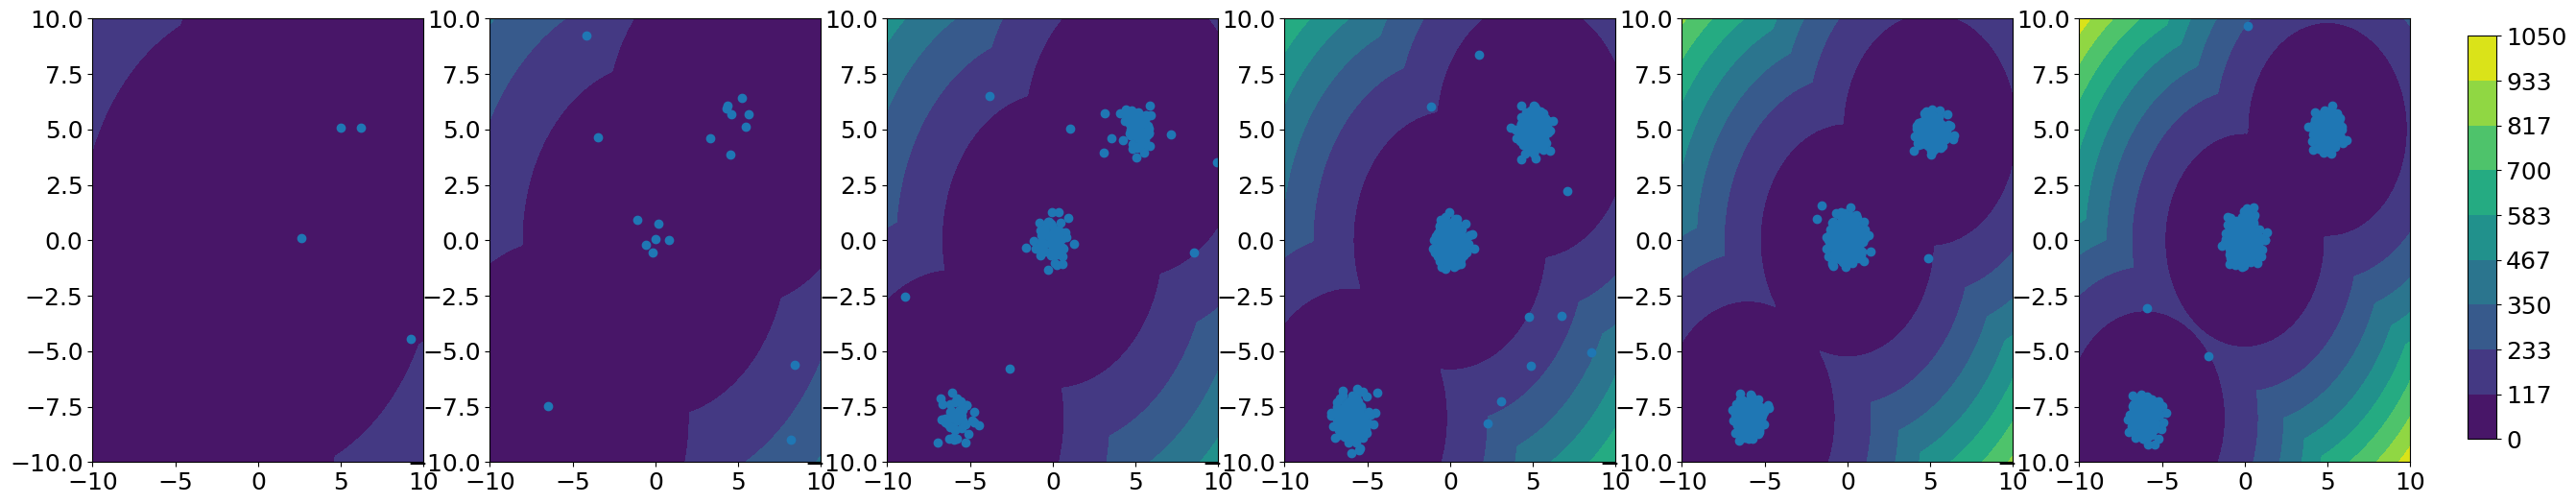

In [ ]:
num_chains = 6
betas = torch.linspace(.2,1.,num_chains, dtype=torch.float32,device=device)
fig, axs = plt.subplots(nrows=1, ncols=num_chains, figsize=(5 * num_chains,6))
samples = torch.randn((1000,2),device=device) #+ torch.tensor([-6,-8.], device=device)
for i, beta in enumerate(betas):
    def temp_log_prob(x):
        return dist.log_prob(x) * beta
    def temp_grad_log_prob(x):
        return dist.grad_log_prob(x) * beta
    
    pts_x = torch.linspace(-10,10, 500)
    pts_y = torch.linspace(-10,10, 500)
    
    xx , yy = torch.meshgrid(pts_x,pts_y,indexing='xy')
    pts_grid = torch.cat((xx.unsqueeze(-1),yy.unsqueeze(-1)),dim=-1).to(device='cuda')
    dens = -temp_log_prob(pts_grid).squeeze(-1).cpu().numpy()
    im = axs[i].contourf(pts_x.cpu().numpy(),pts_y.cpu().numpy(),dens,levels=np.linspace(0.0,1050,10))
    
    sampples = get_ula_samples(samples, temp_grad_log_prob, .1,100000)
    axs[i].set_xlim(-10,10)
    axs[i].set_ylim(-10,10)
    axs[i].scatter(sampples[:,0].cpu(),sampples[:,1].cpu())
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

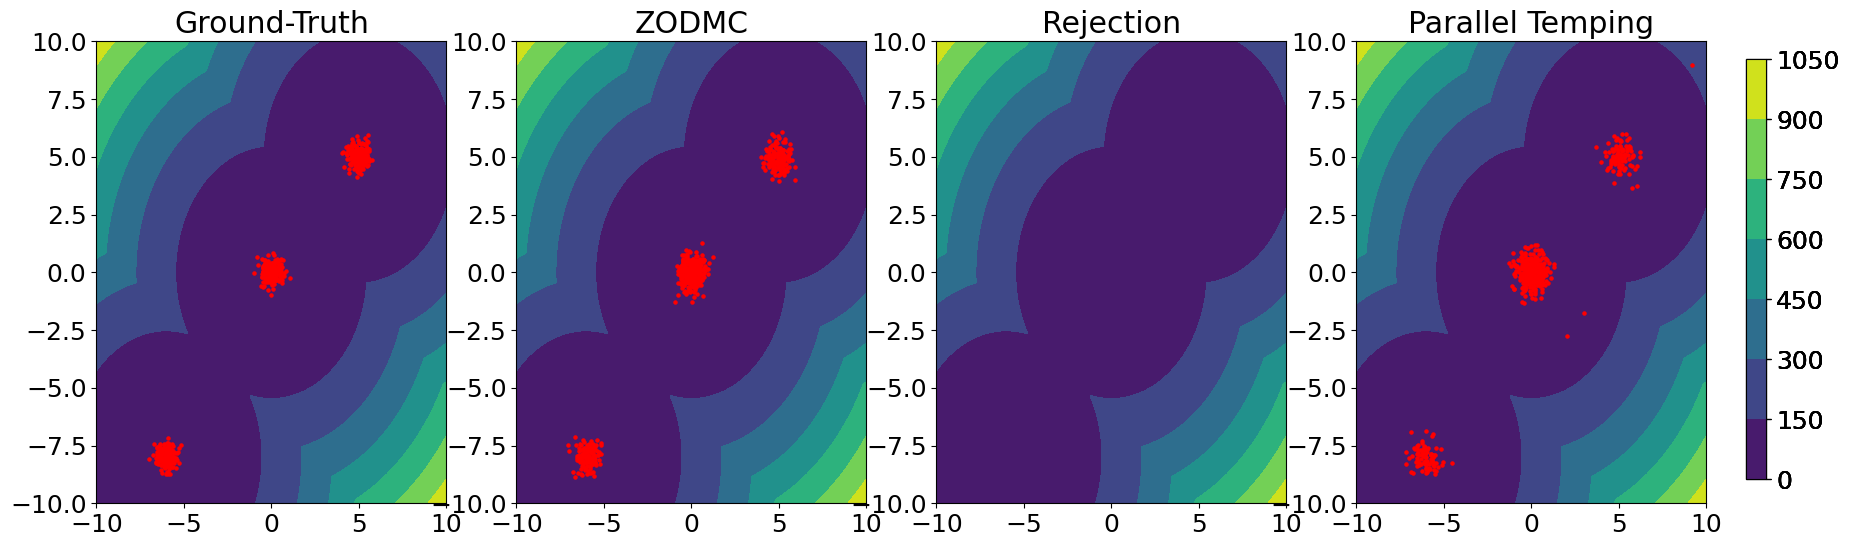

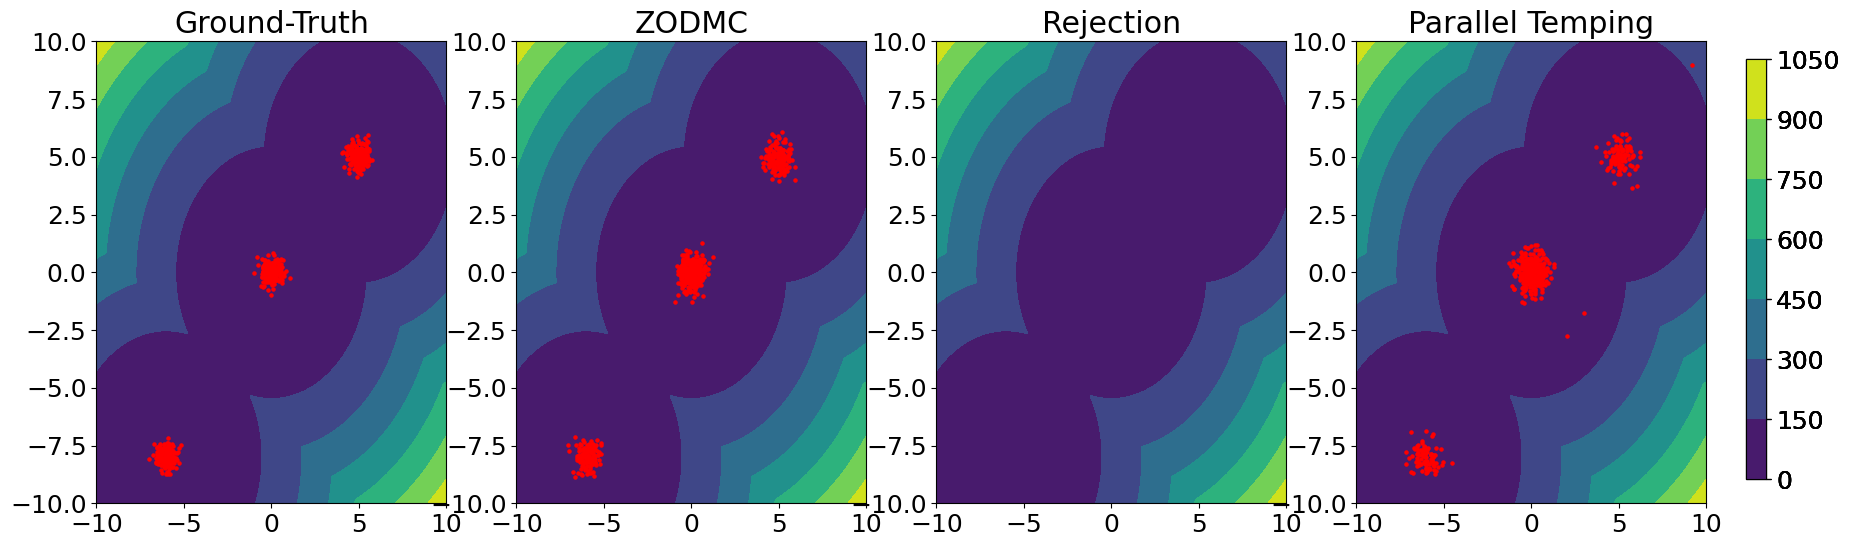

In [ ]:
plots.plot_all_samples(
    [ground_truth_samples,zodmc_samples, rej_samples, parallel_temp_samples],
    ['Ground-Truth','ZODMC','Rejection','Parallel Temping'],
    [-10,10], [-10,10],
    dist.log_prob
)
# print(f'Oracle complexity zodmc     {oracle_complexity_zodmc : 10} with W2 {metrics.get_w2(ground_truth_samples, zodmc_samples) : 4}')
# print(f'Oracle complexity rejection {oracle_complexity_rej : 10} with W2 {metrics.get_w2(ground_truth_samples, rej_samples) : 4}')
# print(f'Oracle complexity parallel  {oracle_complexity_parallel : 10} with W2 {metrics.get_w2(ground_truth_samples, parallel_temp_samples) : 4}')


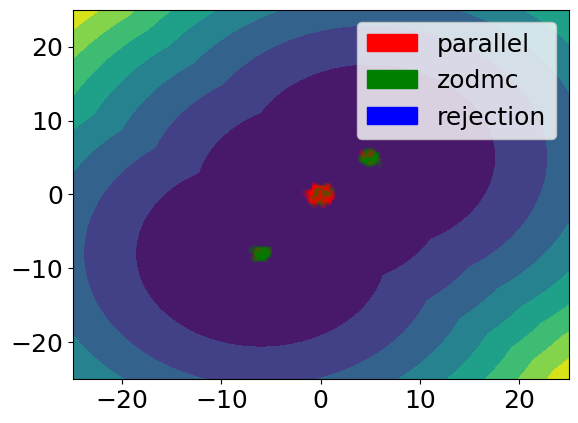

In [ ]:
num_chains = 25
pts_x = torch.linspace(-num_chains, num_chains, 500)
pts_y = torch.linspace(-num_chains, num_chains, 500)

xx , yy = torch.meshgrid(pts_x,pts_y,indexing='xy')
pts_grid = torch.cat((xx.unsqueeze(-1),yy.unsqueeze(-1)),dim=-1).to(device='cuda')
dens = -dist.log_prob(pts_grid).squeeze(-1).cpu().numpy()
pts_x, pts_y = pts_x.cpu().detach().numpy(), pts_y.cpu().detach().numpy()
plt.contourf(pts_x,pts_y,dens)


x0 = parallel_temp_samples[:,0].cpu().detach().numpy()
x1 = zodmc_samples[:,0].cpu().detach().numpy()
y0 = parallel_temp_samples[:,1].cpu().detach().numpy()
y1 = zodmc_samples[:,1].cpu().detach().numpy()
x = np.concatenate((x0,x1))
y = np.concatenate((y0,y1))
cols = np.concatenate((np.tile("r",len(x0)),np.tile("g",len(x1))))
names = np.concatenate((np.tile("parallel",len(x0)),np.tile("zodmc",len(x1))))

rng = np.random.default_rng()
neworder=rng.permutation(len(x))

x_shuffled = x[neworder]
y_shuffled = y[neworder]
cols_shuffled = cols[neworder]
names_shuffled = names[neworder]
plt.xlim([-num_chains,num_chains])
plt.ylim([-num_chains,num_chains])
plt.scatter(x_shuffled, y_shuffled, s=10, alpha=0.2, c=cols_shuffled)
plt.scatter(rej_samples[:,0].cpu().detach().numpy(), rej_samples[:,1].cpu().detach().numpy(), s=10, alpha=0.6, c='blue', label='rejection')

R1 = mpatches.Patch(color='red', label='parallel')
R2 = mpatches.Patch(color='green', label='zodmc')
R3 = mpatches.Patch(color='blue', label='rejection')
plt.legend(handles=[R1,R2,R3])
plt.show()

In [1]:
import torch

from utils.metrics import compute_log_normalizing_constant
from sde_lib import VP
from utils.gmm_score import get_gmm_density_at_t_no_config
import utils.densities as distributions


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sde = VP()
num_modes = 3
s1, s2, s3 = .1, .1, .1 # These are squared
weights = torch.ones((num_modes),dtype=torch.float32,device=device)/num_modes
means = torch.tensor([[0.,0.],[5.,5.], [-6.,-8.0]],dtype=torch.float32,device=device)
id = torch.eye(2,device=device).unsqueeze(0)
covs = torch.cat([s1 * id, s2 * id, s3 * id],dim=0)
gaussians = [distributions.MultivariateGaussian(means[i],covs[i]) for i in range(num_modes)]
dist = distributions.MixtureDistribution(weights, gaussians)
def score(x,t):
    dist_t = get_gmm_density_at_t_no_config(sde,t,weights,means,covs)
    return dist_t.grad_log_prob(x)
compute_log_normalizing_constant(dist,sde,score)

tensor([[0.0728]], device='cuda:0', grad_fn=<AddBackward0>)

In [2]:
import numpy as np
np.exp(0.0728)

1.075515412320497